In [1]:
import chainer
from chainer import Link, Chain, ChainList, Variable, optimizers, iterators
import chainer.functions as F
import chainer.links as L
from chainer import cuda
from chainer import initializers
from chainer import serializers

import os
import time, datetime
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import coordinate
import data
from model import oplus, Generator
import xp_settings as settings
settings.set_gpu(0)
xp = settings.xp


In [2]:
def plot_path(cart_path,target):
    fig = plt.figure()
    path = cart_path
    target = target
    if(settings.gpu_index >= 0):
        path = xp.asnumpy(path)
        target = xp.asnumpy(target)
    plt.scatter(target[:,0],target[:,1],c="red",s=80,marker="o")
    for i in range(1,len(path)):
        plt.quiver(path[i-1,0],path[i-1,1]
                   , path[i,0]-path[i-1,0],path[i,1]-path[i-1,1]
                   , scale_units='xy', angles='xy', scale=1,color="blue")
    num_step = len(target)
    #plt.scatter(t[num_step-1,0],t[num_step-1,1],c="yellow",s=500,marker="*")
    plt.xlabel("x[m]")
    plt.ylabel("y[m]")
    plt.axis('scaled')
    plt.grid()
    plt.show()
    return fig

In [3]:
print('Sample 1 : check Oplus')
sample_x1 = Variable(xp.array([1, 1, 1], dtype = 'float32'))
sample_x2 = Variable(xp.array([1, 2, 0], dtype = 'float32'))
print(sample_x1.shape)
sample_z = oplus(sample_x1,sample_x2)
print(sample_z)
sample_z = sample_z * xp.array([1., 1., 0], dtype='float32')
sample_zt = F.transpose(sample_z)
print(sample_zt)
sample_e = F.matmul(sample_z, sample_zt)
print(sample_e)
print(sample_e.shape)
sample_e.backward()

Sample 1 : check Oplus
(3,)
variable([-0.14263964  2.9220755   1.0000002 ])
variable([-0.14263964  2.9220755   0.        ])
variable(8.558871)
()


Sample 2 : plot Oplus
variable([1.8660254 0.5       1.0471976])
variable([2.3660254 1.3660254 1.5707963])
variable([2.3660254 2.3660254 2.094395 ])
[[1.        0.        0.5235988]
 [1.8660254 0.5       1.0471976]
 [2.3660254 1.3660254 1.5707963]
 [2.3660254 2.3660254 2.094395 ]]


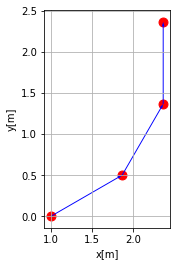

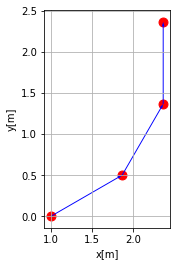

In [4]:
print('Sample 2 : plot Oplus')
sample_x1 = Variable(xp.array([1, 0, xp.pi/6], dtype = 'float32'))
sample_x2 = Variable(xp.array([1, 0, xp.pi/6], dtype = 'float32'))
sample_x3 = Variable(xp.array([1, 0, xp.pi/6], dtype = 'float32'))
sample_x4 = Variable(xp.array([1, 0, xp.pi/6], dtype = 'float32'))
sample_z1 = oplus(sample_x1,sample_x2)
print(sample_z1)
sample_z2 = oplus(sample_z1,sample_x3)
print(sample_z2)
sample_z3 = oplus(sample_z2,sample_x4)
print(sample_z3)
sample_z = sample_z3 * xp.array([1., 1., 0], dtype='float32')
sample_pathes = xp.array(xp.vstack((sample_x1.data,sample_z1.data,sample_z2.data,sample_z3.data)),dtype='float32')
print(sample_pathes)
plot_path(sample_pathes,sample_pathes)

In [5]:
# dataset
DATA_SIZE = 1000
DATA_NUM_WAYPOINTS = 10
DATA_NUM_STEP = DATA_NUM_WAYPOINTS
DATA_HZ = 10
DATA_V_STEP = 1.0 / DATA_HZ # [m/step]
DATA_MAX_V_STEP = 1.0 / DATA_HZ # [m/step]
DATA_W_STEP = (np.pi/6) / DATA_HZ # [rad/step]
DATA_MAX_W_STEP = (np.pi/6) / DATA_HZ # [rad/step]
DATA_NUM_PREVIOUS_U = 0
DATA_RANGE_TRANSLATE = 0 # 経路を直進方向にずらす
DATA_RANGE_ROTATE = 0 # 経路を回転方向にずらす

params = []
params.append('DATA_SIZE            :'+str(DATA_SIZE))
params.append('DATA_NUM_WAYPOINTS   :'+str(DATA_NUM_WAYPOINTS))
params.append('DATA_NUM_STEP        :'+str(DATA_NUM_STEP))
params.append('DATA_V_STEP          :'+str(DATA_V_STEP))
params.append('DATA_MAX_V_STEP      :'+str(DATA_MAX_V_STEP))
params.append('DATA_W_STEP          :'+str(DATA_W_STEP))
params.append('DATA_MAX_W_STEP      :'+str(DATA_MAX_W_STEP))
params.append('DATA_NUM_PREVIOUS_U  :'+str(DATA_NUM_PREVIOUS_U))
params.append('DATA_RANGE_TRANSLATE :'+str(DATA_RANGE_TRANSLATE))
params.append('DATA_RANGE_ROTATE    :'+str(DATA_RANGE_ROTATE))
for a in params:
    print(a)

DATA_SIZE            :1000
DATA_NUM_WAYPOINTS   :10
DATA_NUM_STEP        :10
DATA_V_STEP          :0.1
DATA_MAX_V_STEP      :0.1
DATA_W_STEP          :0.05235987755982988
DATA_MAX_W_STEP      :0.05235987755982988
DATA_NUM_PREVIOUS_U  :0
DATA_RANGE_TRANSLATE :0
DATA_RANGE_ROTATE    :0


In [6]:
X_train = []

for i in range(DATA_SIZE):
    rand_rad = xp.random.rand()*(2*DATA_W_STEP)-DATA_W_STEP # -36 ~ 36 m/step
    d = data.generate_arc_path(DATA_NUM_STEP,rand_rad,DATA_V_STEP)
    d = data.rotate_path(d,rand_rad*0.5)
    if DATA_RANGE_TRANSLATE != 0:
        rand_trans_x = xp.random.rand() * DATA_RANGE_TRANSLATE
        d = data.translate_path(d,rand_trans_x,0.0)
    if DATA_RANGE_ROTATE != 0:
        rand_rotate = xp.random.rand()*(DATA_RANGE_ROTATE*2)-DATA_RANGE_ROTATE
        d = data.rotate_path(d,rand_rotate)
    X_train.append(d)
'''
# old version
for i in range(DATA_SIZE):
    l = int(DATA_NUM_WAYPOINTS*DATA_M_PER_STEP)+1
    rand_rad = xp.random.rand()*(2*DATA_RAD_PER_STEP)-DATA_RAD_PER_STEP # -36 ~ 36 m/step
    d = data.make_arc_path_2(l,rand_rad,s=DATA_M_PER_STEP)
    d_es,_ = data.old_get_evenly_spaced_points(d,DATA_M_PER_STEP)
    d_xy = d_es[0:DATA_NUM_WAYPOINTS]
    X_train.append(d_xy)
'''
print(len(X_train))
print(X_train[0].shape)

1000
(10, 3)


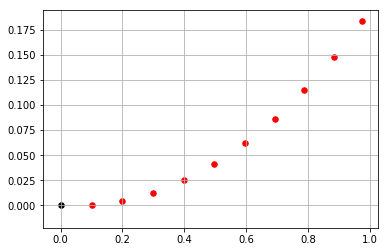

 -- x_train -- 
[[ 9.99928310e-02 -4.08693526e-07 -1.50857224e+00]
 [ 1.99899668e-01  4.14569628e-03 -1.46709224e+00]
 [ 2.99548637e-01  1.24311822e-02 -1.42561224e+00]
 [ 3.98768307e-01  2.48417952e-02 -1.38413224e+00]
 [ 4.97387986e-01  4.13561847e-02 -1.34265224e+00]
 [ 5.95238016e-01  6.19459403e-02 -1.30117224e+00]
 [ 6.92150059e-01  8.65756406e-02 -1.25969224e+00]
 [ 7.87957394e-01  1.15202914e-01 -1.21821224e+00]
 [ 8.82495200e-01  1.47778512e-01 -1.17673224e+00]
 [ 9.75600838e-01  1.84246393e-01 -1.13525224e+00]]


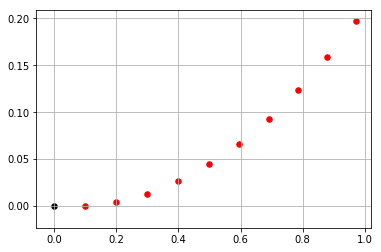

 -- x_train -- 
[[ 9.99917232e-02 -4.11142965e-08 -1.50394092e+00]
 [ 1.99884149e-01  4.45507356e-03 -1.45937092e+00]
 [ 2.99478874e-01  1.33564955e-02 -1.41480092e+00]
 [ 3.98578090e-01  2.66865450e-02 -1.37023092e+00]
 [ 4.96984968e-01  4.44187466e-02 -1.32566092e+00]
 [ 5.94504058e-01  6.65178813e-02 -1.28109092e+00]
 [ 6.90941672e-01  9.29400568e-02 -1.23652092e+00]
 [ 7.86106269e-01  1.23632795e-01 -1.19195092e+00]
 [ 8.79808838e-01  1.58535134e-01 -1.14738092e+00]
 [ 9.71863271e-01  1.97577754e-01 -1.10281092e+00]]


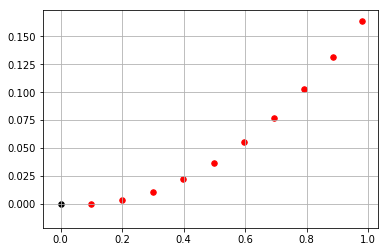

 -- x_train -- 
[[ 9.99943482e-02 -4.27373869e-07 -1.51554705e+00]
 [ 1.99920901e-01  3.68110486e-03 -1.47871705e+00]
 [ 2.99644129e-01  1.10396034e-02 -1.44188705e+00]
 [ 3.99028778e-01  2.20650881e-02 -1.40505705e+00]
 [ 4.97940052e-01  3.67426050e-02 -1.36822705e+00]
 [ 5.96243799e-01  5.50522471e-02 -1.33139705e+00]
 [ 6.93806690e-01  7.69691811e-02 -1.29456705e+00]
 [ 7.90496400e-01  1.02463681e-01 -1.25773705e+00]
 [ 8.86181791e-01  1.31501169e-01 -1.22090705e+00]
 [ 9.80733084e-01  1.64042262e-01 -1.18407705e+00]]


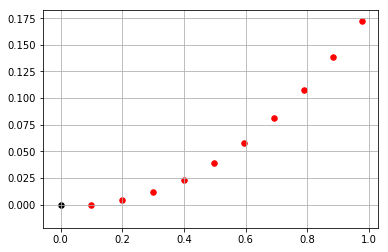

 -- x_train -- 
[[ 9.99937177e-02 -1.90516205e-07 -1.51254942e+00]
 [ 1.99912069e-01  3.88139953e-03 -1.47371942e+00]
 [ 2.99604418e-01  1.16389183e-02 -1.43488942e+00]
 [ 3.98920471e-01  2.32606708e-02 -1.39605942e+00]
 [ 4.97710502e-01  3.87291363e-02 -1.35722942e+00]
 [ 5.95825576e-01  5.80209947e-02 -1.31839942e+00]
 [ 6.93117778e-01  8.11071622e-02 -1.27956942e+00]
 [ 7.89440431e-01  1.07952834e-01 -1.24073942e+00]
 [ 8.84648321e-01  1.38517540e-01 -1.20190942e+00]
 [ 9.78597915e-01  1.72755199e-01 -1.16307942e+00]]


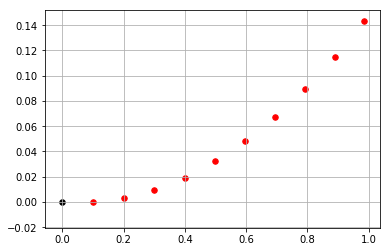

 -- x_train -- 
[[ 9.99956933e-02 -4.22021526e-07 -1.52256711e+00]
 [ 1.99939726e-01  3.21346392e-03 -1.49041711e+00]
 [ 2.99728802e-01  9.63833616e-03 -1.45826711e+00]
 [ 3.99259786e-01  1.92675544e-02 -1.42611711e+00]
 [ 4.98429810e-01  3.20911665e-02 -1.39396711e+00]
 [ 5.97136378e-01  4.80959188e-02 -1.36181711e+00]
 [ 6.95277474e-01  6.72652699e-02 -1.32966711e+00]
 [ 7.92751665e-01  8.95794076e-02 -1.29751711e+00]
 [ 8.89458209e-01  1.15015270e-01 -1.26536711e+00]
 [ 9.85297156e-01  1.43546567e-01 -1.23321711e+00]]


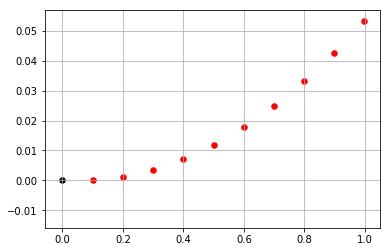

 -- x_train -- 
[[ 9.99994159e-02 -4.04293845e-07 -1.55303228e+00]
 [ 1.99991827e-01  1.18315686e-03 -1.54119228e+00]
 [ 2.99963217e-01  3.55051755e-03 -1.52935228e+00]
 [ 3.99899571e-01  7.10134591e-03 -1.51751228e+00]
 [ 4.99786879e-01  1.18351442e-02 -1.50567228e+00]
 [ 5.99611139e-01  1.77512487e-02 -1.49383228e+00]
 [ 6.99358357e-01  2.48488302e-02 -1.48199228e+00]
 [ 7.99014550e-01  3.31268937e-02 -1.47015228e+00]
 [ 8.98565749e-01  4.25842787e-02 -1.45831228e+00]
 [ 9.97997996e-01  5.32196595e-02 -1.44647228e+00]]


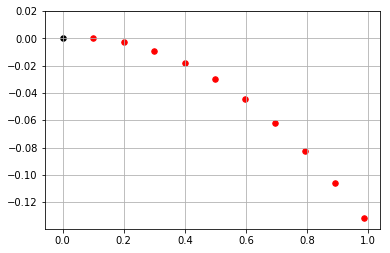

 -- x_train -- 
[[ 9.99963765e-02  2.74498210e-07 -1.61503407e+00]
 [ 1.99949283e-01 -2.94791686e-03 -1.64452407e+00]
 [ 2.99771800e-01 -8.84201034e-03 -1.67401407e+00]
 [ 3.99377123e-01 -1.76768804e-02 -1.70350407e+00]
 [ 4.98678635e-01 -2.94448444e-02 -1.73299407e+00]
 [ 5.97589984e-01 -4.41356688e-02 -1.76248407e+00]
 [ 6.96025157e-01 -6.17365786e-02 -1.79197407e+00]
 [ 7.93898555e-01 -8.22322681e-02 -1.82146407e+00]
 [ 8.91125068e-01 -1.05604914e-01 -1.85095407e+00]
 [ 9.87620147e-01 -1.31834192e-01 -1.88044407e+00]]


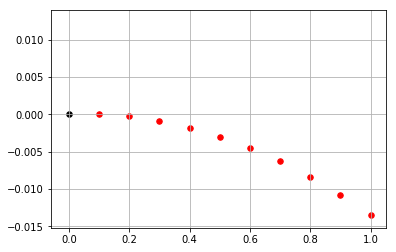

 -- x_train -- 
[[ 9.99999622e-02  1.36365718e-08 -1.57531146e+00]
 [ 1.99999472e-01 -3.00972159e-04 -1.57832146e+00]
 [ 2.99997622e-01 -9.02954659e-04 -1.58133146e+00]
 [ 3.99993507e-01 -1.80592841e-03 -1.58434146e+00]
 [ 4.99986222e-01 -3.00988523e-03 -1.58735146e+00]
 [ 5.99974859e-01 -4.51481421e-03 -1.59036146e+00]
 [ 6.99958514e-01 -6.32070172e-03 -1.59337146e+00]
 [ 7.99936280e-01 -8.42753140e-03 -1.59638146e+00]
 [ 8.99907252e-01 -1.08352842e-02 -1.59939146e+00]
 [ 9.99870523e-01 -1.35439382e-02 -1.60240146e+00]]


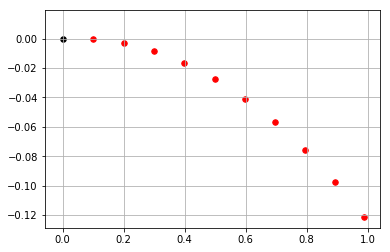

 -- x_train -- 
[[ 9.99969174e-02  4.74246288e-07 -1.61160107e+00]
 [ 1.99956859e-01 -2.71863246e-03 -1.63880107e+00]
 [ 2.99805875e-01 -8.15530855e-03 -1.66600107e+00]
 [ 3.99470098e-01 -1.63055320e-02 -1.69320107e+00]
 [ 4.98875797e-01 -2.71632733e-02 -1.72040107e+00]
 [ 5.97949432e-01 -4.07205000e-02 -1.74760107e+00]
 [ 6.96617708e-01 -5.69671824e-02 -1.77480107e+00]
 [ 7.94807632e-01 -7.58913015e-02 -1.80200107e+00]
 [ 8.92446564e-01 -9.74788573e-02 -1.82920107e+00]
 [ 9.89462269e-01 -1.21713879e-01 -1.85640107e+00]]


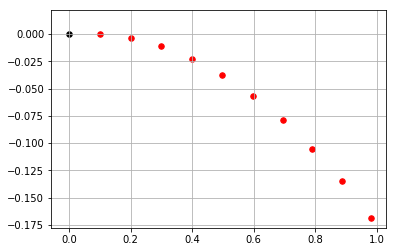

 -- x_train -- 
[[ 9.99940466e-02  3.38555879e-07 -1.62749971e+00]
 [ 1.99916677e-01 -3.77819804e-03 -1.66529971e+00]
 [ 2.99625134e-01 -1.13302115e-02 -1.70309971e+00]
 [ 3.98976968e-01 -2.26449125e-02 -1.74089971e+00]
 [ 4.97830237e-01 -3.77061361e-02 -1.77869971e+00]
 [ 5.96043714e-01 -5.64923647e-02 -1.81649971e+00]
 [ 6.93477083e-01 -7.89767590e-02 -1.85429971e+00]
 [ 7.89991144e-01 -1.05127196e-01 -1.89209971e+00]
 [ 8.85448011e-01 -1.34906316e-01 -1.92989971e+00]
 [ 9.79711306e-01 -1.68271574e-01 -1.96769971e+00]]


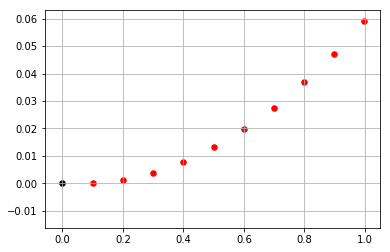

 -- x_train -- 
[[ 9.99992806e-02 -1.42107243e-08 -1.55108618e+00]
 [ 1.99989929e-01  1.31392431e-03 -1.53794618e+00]
 [ 2.99954680e-01  3.94158872e-03 -1.52480618e+00]
 [ 3.99876275e-01  7.88252531e-03 -1.51166618e+00]
 [ 4.99737461e-01  1.31360537e-02 -1.49852618e+00]
 [ 5.99520997e-01  1.97012667e-02 -1.48538618e+00]
 [ 6.99209655e-01  2.75770309e-02 -1.47224618e+00]
 [ 7.98786222e-01  3.67619865e-02 -1.45910618e+00]
 [ 8.98233506e-01  4.72545476e-02 -1.44596618e+00]
 [ 9.97534337e-01  5.90529026e-02 -1.43282618e+00]]


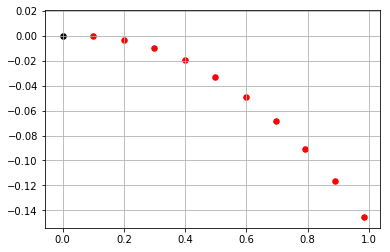

 -- x_train -- 
[[ 9.99955529e-02  3.35318771e-07 -1.61980468e+00]
 [ 1.99937757e-01 -3.26560315e-03 -1.65247468e+00]
 [ 2.99719952e-01 -9.79432988e-03 -1.68514468e+00]
 [ 3.99235645e-01 -1.95788772e-02 -1.71781468e+00]
 [ 4.98378631e-01 -3.26088027e-02 -1.75048468e+00]
 [ 5.97043100e-01 -4.88702004e-02 -1.78315468e+00]
 [ 6.95123755e-01 -6.83457156e-02 -1.81582468e+00]
 [ 7.92515921e-01 -9.10145634e-02 -1.84849468e+00]
 [ 8.89115657e-01 -1.16852551e-01 -1.88116468e+00]
 [ 9.84819869e-01 -1.45832103e-01 -1.91383468e+00]]


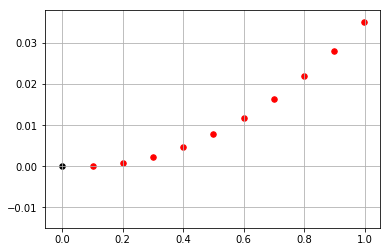

 -- x_train -- 
[[ 9.99997445e-02 -2.33102698e-07 -1.55904900e+00]
 [ 1.99996425e-01  7.82523801e-04 -1.55121900e+00]
 [ 2.99983912e-01  2.34822272e-03 -1.54338900e+00]
 [ 3.99956075e-01  4.69676767e-03 -1.53555900e+00]
 [ 4.99906783e-01  7.82801465e-03 -1.52772900e+00]
 [ 5.99829911e-01  1.17417717e-02 -1.51989900e+00]
 [ 6.99719331e-01  1.64377989e-02 -1.51206900e+00]
 [ 7.99568919e-01  2.19158083e-02 -1.50423900e+00]
 [ 8.99372555e-01  2.81754640e-02 -1.49640900e+00]
 [ 9.99124118e-01  3.52163824e-02 -1.48857900e+00]]


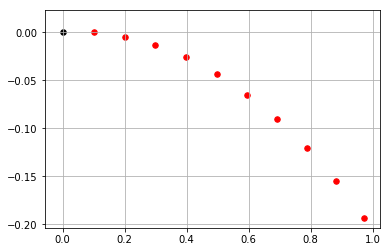

 -- x_train -- 
[[ 9.99921086e-02  2.10143409e-07 -1.63607843e+00]
 [ 1.99889549e-01 -4.34986294e-03 -1.67959843e+00]
 [ 2.99503147e-01 -1.30419816e-02 -1.72311843e+00]
 [ 3.98644264e-01 -2.60596855e-02 -1.76663843e+00]
 [ 4.97125159e-01 -4.33783233e-02 -1.81015843e+00]
 [ 5.94759338e-01 -6.49650987e-02 -1.85367843e+00]
 [ 6.91361912e-01 -9.07791332e-02 -1.89719843e+00]
 [ 7.86749947e-01 -1.20771543e-01 -1.94071843e+00]
 [ 8.80742806e-01 -1.54885531e-01 -1.98423843e+00]
 [ 9.73162496e-01 -1.93056497e-01 -2.02775843e+00]]


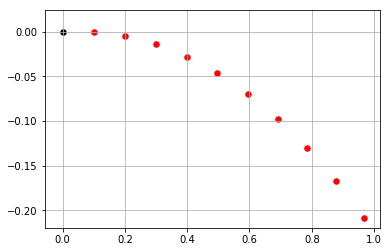

 -- x_train -- 
[[ 9.99907922e-02  3.55034887e-07 -1.64131488e+00]
 [ 1.99871135e-01 -4.69812633e-03 -1.68832488e+00]
 [ 2.99420338e-01 -1.40850626e-02 -1.73533488e+00]
 [ 3.98418446e-01 -2.81397131e-02 -1.78234488e+00]
 [ 4.96646718e-01 -4.68310236e-02 -1.82935488e+00]
 [ 5.93888116e-01 -7.01176950e-02 -1.87636488e+00]
 [ 6.89927781e-01 -9.79482746e-02 -1.92337488e+00]
 [ 7.84553512e-01 -1.30261270e-01 -1.97038488e+00]
 [ 8.77556228e-01 -1.66985284e-01 -2.01739488e+00]
 [ 9.68730438e-01 -2.08039175e-01 -2.06440488e+00]]


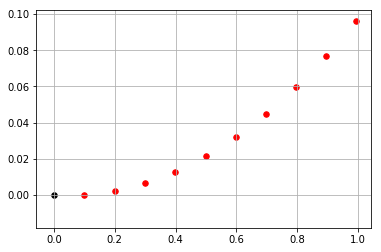

 -- x_train -- 
[[ 9.99980829e-02 -4.88651584e-07 -1.53861644e+00]
 [ 1.99973173e-01  2.14381721e-03 -1.51716644e+00]
 [ 2.99879272e-01  6.43193102e-03 -1.49571644e+00]
 [ 3.99670415e-01  1.28618799e-02 -1.47426644e+00]
 [ 4.99300691e-01  2.14307055e-02 -1.45281644e+00]
 [ 5.98724260e-01  3.21344654e-02 -1.43136644e+00]
 [ 6.97895380e-01  4.49682350e-02 -1.40991644e+00]
 [ 7.96768422e-01  5.99261098e-02 -1.38846644e+00]
 [ 8.95297898e-01  7.70012077e-02 -1.36701644e+00]
 [ 9.93438475e-01  9.61856728e-02 -1.34556644e+00]]


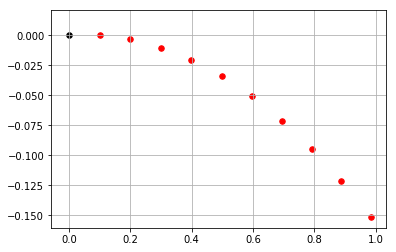

 -- x_train -- 
[[ 9.99951721e-02  2.41018221e-07 -1.62185874e+00]
 [ 1.99932425e-01 -3.40269645e-03 -1.65589874e+00]
 [ 2.99695969e-01 -1.02048697e-02 -1.68993874e+00]
 [ 3.99170220e-01 -2.03983977e-02 -1.72397874e+00]
 [ 4.98239923e-01 -3.39714702e-02 -1.75801874e+00]
 [ 5.96790297e-01 -5.09083612e-02 -1.79205874e+00]
 [ 6.94707159e-01 -7.11894474e-02 -1.82609874e+00]
 [ 7.91877063e-01 -9.47912311e-02 -1.86013874e+00]
 [ 8.88187427e-01 -1.21686367e-01 -1.89417874e+00]
 [ 9.83526663e-01 -1.51843694e-01 -1.92821874e+00]]


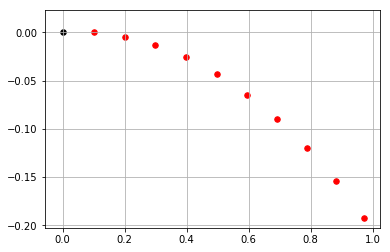

 -- x_train -- 
[[ 9.99921917e-02  3.04731646e-07 -1.63573437e+00]
 [ 1.99890717e-01 -4.32670093e-03 -1.67902437e+00]
 [ 2.99508394e-01 -1.29729093e-02 -1.72231437e+00]
 [ 3.98658565e-01 -2.59221198e-02 -1.76560437e+00]
 [ 4.97155449e-01 -4.31500690e-02 -1.80889437e+00]
 [ 5.94814490e-01 -6.46244764e-02 -1.85218437e+00]
 [ 6.91452700e-01 -9.03051047e-02 -1.89547437e+00]
 [ 7.86889007e-01 -1.20143835e-01 -1.93876437e+00]
 [ 8.80944587e-01 -1.54084758e-01 -1.98205437e+00]
 [ 9.73443206e-01 -1.92064278e-01 -2.02534437e+00]]


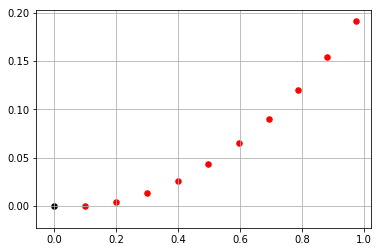

 -- x_train -- 
[[ 9.99922062e-02 -2.61208629e-07 -1.50591871e+00]
 [ 1.99890917e-01  4.32279261e-03 -1.46266871e+00]
 [ 2.99509296e-01  1.29610762e-02 -1.41941871e+00]
 [ 3.98661029e-01  2.58984336e-02 -1.37616871e+00]
 [ 4.97160675e-01  4.31106684e-02 -1.33291871e+00]
 [ 5.94824013e-01  6.45655891e-02 -1.28966871e+00]
 [ 6.91468387e-01  9.02230693e-02 -1.24641871e+00]
 [ 7.86913045e-01  1.20035122e-01 -1.20316871e+00]
 [ 8.80979480e-01  1.53945992e-01 -1.15991871e+00]
 [ 9.73491763e-01  1.91892255e-01 -1.11666871e+00]]


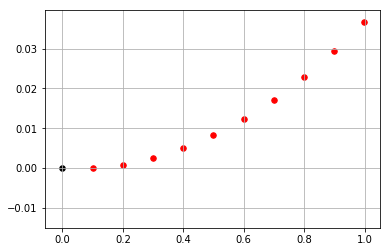

 -- x_train -- 
[[ 9.99997205e-02 -6.37329550e-08 -1.55851069e+00]
 [ 1.99996088e-01  8.18861091e-04 -1.55032069e+00]
 [ 2.99982394e-01  2.45671954e-03 -1.54213069e+00]
 [ 3.99951934e-01  4.91340176e-03 -1.53394069e+00]
 [ 4.99898001e-01  8.18874296e-03 -1.52575069e+00]
 [ 5.99813891e-01  1.22825235e-02 -1.51756069e+00]
 [ 6.99692902e-01  1.71944686e-02 -1.50937069e+00]
 [ 7.99528335e-01  2.29242490e-02 -1.50118069e+00]
 [ 8.99313494e-01  2.94714803e-02 -1.49299069e+00]
 [ 9.99041684e-01  3.68357234e-02 -1.48480069e+00]]


In [7]:
# plot data
p = X_train
random.shuffle(p)
if(settings.gpu_index >= 0):
    p = chainer.cuda.to_cpu(X_train)

for num in range(20):
    plt.scatter(0, 0,c="black",edgecolor="black",s=30,marker="o")
    plt.scatter(p[num][:,0], p[num][:,1],c="red",edgecolor="red",s=30,marker="o")
    #plt.xlim([-.2,.2])
    #plt.ylim([-.2,.2])
    plt.grid()
    plt.show()
    print(' -- x_train -- ')
    print(p[num])

In [8]:
# loss
def error_squares(z_oplus,z_true):
    w = xp.array([1., 1., 0.],dtype=xp.float32)
    t = z_true * w
    p = z_oplus * w
    error = F.sqrt(F.sum((t-p)*(t-p)))
    return error

def error_diff_v(y0, y1):
    w = xp.array([0., 0., 1.],dtype=xp.float32)
    v0 = y0 * w
    v1 = y1 * w
    error = F.absolute(F.sum(v1 - v0))
    return error

def error_diff_w(y0, y1):
    w = xp.array([0., 0., 1.],dtype=xp.float32)
    v0 = y0 * w
    v1 = y1 * w
    error = F.absolute(F.sum(v1 - v0))
    return error

def calc_oplus(y):
    dst = []
    z = y[0,0]
    dst.append(z)
    for step in range(1,DATA_NUM_STEP):
        z = oplus(z,y[0,step])
        dst.append(z)
    return dst

def loss_function(y, y_true,disp_loss=0):
    dmesg = ''
    z_true = y_true
    z_oplus = calc_oplus(y)
    # distance - stage cost
    e_distance = error_squares(z_oplus[0],z_true[0])
    for i in range(1,DATA_NUM_WAYPOINTS-1):
        e_distance = e_distance + error_squares(z_oplus[i],z_true[i])
    # distance - terminal cost
    e_distance = e_distance + 10 * error_squares(z_oplus[-1],z_true[-1])
    dmesg = dmesg + 'e_distance: ' + str(e_distance) + '\t'
    '''
    e_diff_v = error_diff_v(y[0,0],y[0,1])
    for i in range(2,DATA_NUM_STEP):
        e_diff_v = e_diff_v + error_diff_v(y[0,i-1],y[0,i])
    dmesg = dmesg + 'e_dv: ' + str(e_diff_v) + '\t'
    e_diff_w = error_diff_v(y[0,0],y[0,1])
    for i in range(2,DATA_NUM_STEP):
        e_diff_w = e_diff_w + error_diff_w(y[0,i-1],y[0,i])
    dmesg = dmesg + 'e_dw: ' + str(e_diff_w) + '\t'
    '''    
    loss = (1 * e_distance)
    #loss = loss + (1 * e_lim_w)
    #loss = loss + (1 * e_lim_v)
    #loss = loss + (1 * e_diff_v)
    #loss = loss + (1 * e_diff_w)
    if(disp_loss):
        print(dmesg)
    return loss

In [9]:
# training
def train(model,opt,X,epoch=10,clipping=0):
    ep = 0
    AvgLoss = []
    while ep < epoch:
        random.shuffle(X)
        L = .0
        for itr in range(len(X)):
            # forward
            x = X[itr][:,0:2]
            if(DATA_NUM_PREVIOUS_U):
                prev_u = xp.zeros((DATA_NUM_PREVIOUS_U,2),dtype=xp.float32)
                x = xp.vstack((x,prev_u))
            x = xp.ravel(x)
            x = Variable(xp.array([x],dtype=xp.float32))
            y_v, y_w = model(x)
            # clip
            if clipping:
                v_limit = DATA_MAX_V_STEP
                w_limit = DATA_MAX_W_STEP
                v = F.clip(y_v,0.0,v_limit)
                w = F.clip(y_w,-w_limit,w_limit)
            else:
                v = y_v
                w = y_w
            # zero-padding
            pad = Variable(xp.zeros((1,DATA_NUM_STEP),dtype=xp.float32))
            y_pad = F.stack((v,pad,w),axis=2)
            
            # loss
            loss = loss_function(y_pad, X[itr][:])
            
            # update
            model.cleargrads()
            loss.backward()
            opt.update()
            #y_grad = chainer.grad( (e,), (y,) )[0]
            #print(y_grad)
            #x_grad = chainer.grad( (e,), (x,) )[0]
            #print(x_grad)
            L = L + loss.data
        ep = ep + 1
        print('Epoch:',ep,', Average loss:',L / len(X))
        AvgLoss.append(L / len(X))
    return model, AvgLoss

In [10]:
EPOCH = 30
model = Generator(DATA_NUM_WAYPOINTS,DATA_NUM_PREVIOUS_U,DATA_NUM_STEP)
start_time = '{0:%Y/%m/%d %H:%M:%S}'.format(datetime.datetime.now())
if settings.gpu_index >= 0:
    cuda.cupy.cuda.Device(settings.gpu_index).use()
    model.to_gpu(settings.gpu_index)
opt = optimizers.Adam()
opt.setup(model)
model,loss_avg = train(model,opt,X_train,epoch=EPOCH,clipping=0)
model,loss_avg_clip = train(model,opt,X_train,epoch=EPOCH,clipping=1)
finish_time = '{0:%Y/%m/%d %H:%M:%S}'.format(datetime.datetime.now())
print('start:',start_time)
print('finish:',finish_time)

Epoch: 1 , Average loss: 1.9467484
Epoch: 2 , Average loss: 0.36101
Epoch: 3 , Average loss: 0.23861271
Epoch: 4 , Average loss: 0.23696144
Epoch: 5 , Average loss: 0.19894375
Epoch: 6 , Average loss: 0.19071949
Epoch: 7 , Average loss: 0.18044063
Epoch: 8 , Average loss: 0.14983633
Epoch: 9 , Average loss: 0.1321917
Epoch: 10 , Average loss: 0.110996604
Epoch: 11 , Average loss: 0.112689145
Epoch: 12 , Average loss: 0.08998073
Epoch: 13 , Average loss: 0.0856987
Epoch: 14 , Average loss: 0.09850834
Epoch: 15 , Average loss: 0.07848483
Epoch: 16 , Average loss: 0.08519958
Epoch: 17 , Average loss: 0.085705556
Epoch: 18 , Average loss: 0.07701268
Epoch: 19 , Average loss: 0.092612006
Epoch: 20 , Average loss: 0.082956076
Epoch: 21 , Average loss: 0.07290883
Epoch: 22 , Average loss: 0.065139376
Epoch: 23 , Average loss: 0.0724521
Epoch: 24 , Average loss: 0.076828554
Epoch: 25 , Average loss: 0.06936805
Epoch: 26 , Average loss: 0.0742317
Epoch: 27 , Average loss: 0.074087195
Epoch: 28 

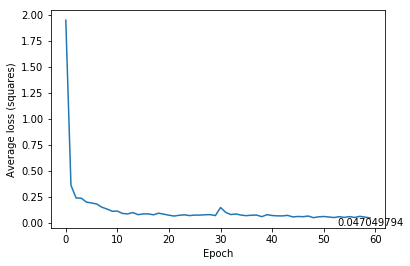

In [11]:
def plot_average_loss(loss_avg):
    fig = plt.figure()
    plt.plot(range(len(loss_avg)),loss_avg)
    plt.xlabel('Epoch')
    plt.ylabel('Average loss (squares)') #*10, lim_v, lim_w, )')
    plt.text(len(loss_avg)-1, loss_avg[-1],str(loss_avg[-1]),ha='center',va='top' )
    return fig
loss_avg.extend(loss_avg_clip)
fig = plot_average_loss(loss_avg)

In [12]:
# log
def gen_filename(header):
    name_date = '{0:%Y%m%d%H%M}'.format(datetime.datetime.now())
    name_epoch = '{}ep'.format(EPOCH)
    name_datasize  = '{}data'.format(DATA_SIZE)
    name_num_step = '{}step'.format(DATA_NUM_STEP)
    name_space = '{}mm'.format(int(DATA_V_STEP * 1000))
    #fn = header + name_space + name_num_step + '_' + name_date + '_'   + name_datasize + name_epoch
    fn = header + name_space + name_num_step + '_' + name_date
    return fn
dirname = gen_filename('w')
os.mkdir(dirname)
print(dirname)

w100mm10step_201912051858


In [13]:
f = open(dirname+'/params.txt','w')
for l in params:
    f.write(l+'\n')
f.close()
serializers.save_npz(dirname +'/'+ dirname+'.model', model)
serializers.save_npz(dirname +'/'+ dirname+'.state', opt)
fig.savefig(dirname + '/' + 'loss.png')

 --- input --- 
[[ 9.99993542e-02 -4.36019041e-07 -1.55211697e+00]
 [ 1.99990964e-01  1.24408779e-03 -1.53966697e+00]
 [ 2.99959330e-01  3.73337853e-03 -1.52721697e+00]
 [ 3.99888958e-01  7.46705036e-03 -1.51476697e+00]
 [ 4.99764358e-01  1.24445246e-02 -1.50231697e+00]
 [ 5.99570050e-01  1.86650296e-02 -1.48986697e+00]
 [ 6.99290564e-01  2.61276013e-02 -1.47741697e+00]
 [ 7.98910443e-01  3.48310830e-02 -1.46496697e+00]
 [ 8.98414245e-01  4.47741256e-02 -1.45251697e+00]
 [ 9.97786549e-01  5.59551880e-02 -1.44006697e+00]]
 --- output --- 
[[[ 0.1         0.          0.01255657]
  [ 0.1         0.          0.01240172]
  [ 0.1         0.          0.01178917]
  [ 0.1         0.          0.00984025]
  [ 0.1         0.          0.00163696]
  [ 0.1         0.          0.01578454]
  [ 0.1         0.          0.03540474]
  [ 0.1         0.         -0.05235988]
  [ 0.1         0.          0.05235988]
  [ 0.1         0.          0.05235988]]]
 --- error --- 
e_distance: variable(0.09473033)	
loss

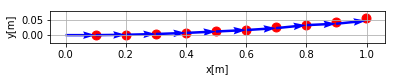

 --- grad --- 
variable([[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]])
variable([[-11.994526  -10.595998   -9.096983   -7.497937   -5.9982862
            -4.5985856  -3.2986493   0.          0.          0.       ]])


In [14]:
rand_rad = xp.random.rand()*(2*DATA_W_STEP)-DATA_W_STEP # -36 ~ 36 m/step
d = data.generate_arc_path(DATA_NUM_STEP,rand_rad,DATA_V_STEP)
d = data.rotate_path(d,rand_rad*0.5)
if DATA_RANGE_TRANSLATE != 0:
    rand_trans_x = xp.random.rand() * DATA_RANGE_TRANSLATE
    d = data.translate_path(d,rand_trans_x,0.0)
if DATA_RANGE_ROTATE != 0:
    rand_rotate = xp.random.rand()*(DATA_RANGE_ROTATE*2)-DATA_RANGE_ROTATE
    d = data.rotate_path(d,rand_rotate)
x_test = d
'''
x_test = xp.array(
    [[ 0.02293546, -0.04092823,0],
     [ 0.05309581, -0.05415406,0],
     [ 0.08393338, -0.06682136,0],
     [ 0.11579048, -0.07606434,0],
     [ 0.14647007, -0.08932315,0],
     [ 0.17848524, -0.09797464,0],
     [ 0.21082233, -0.10660645,0],
     [ 0.24306089, -0.11521195,0],
     [ 0.27361556, -0.12854306,0],
     [ 0.3055584,  -0.13706963,0]]
    , dtype = xp.float32)
'''

x = x_test[:,0:2]
if DATA_NUM_PREVIOUS_U:
    prev_u = xp.array([.0,.0],dtype=xp.float32)
    x = xp.vstack((x,prev_u))
x = xp.ravel(x)
x = xp.array([x],dtype=xp.float32)
y_v,y_w = model(x)
# clip
v_limit = DATA_MAX_V_STEP
w_limit = DATA_MAX_W_STEP
v = F.clip(y_v,0.0,v_limit)
w = F.clip(y_w,-w_limit,w_limit)
# zero-padding
pad = Variable(xp.zeros((1,DATA_NUM_STEP),dtype=xp.float32))
y_pad = F.stack((v,pad,w),axis=2)
print(' --- input --- ')
print(x_test)
print(' --- output --- ')
print(y_pad.data)
# loss
print(' --- error --- ')
loss = loss_function(y_pad, x_test, disp_loss=1)
print('loss:',loss)
z_true = x_test
z = y_pad[0,0]
Z = xp.array([([0,0,0]),(z.data)],dtype='float32')
for step in range(1,DATA_NUM_STEP):
    z = oplus(z,y_pad[0,step])
    Z = xp.vstack((Z,z.data))
#print(' --- trajectory --- ')
#print(Z)
#print(z_true.shape)
fig = plot_path(Z,z_true)
print(' --- grad --- ')
v_grad = chainer.grad( (loss,), (y_v,) )[0]
print(v_grad)
w_grad = chainer.grad( (loss,), (y_w,) )[0]
print(w_grad)
#x_grad = chainer.grad( (loss,), (x,) )[0]
#print(x_grad)

 --- input --- 
[[ 9.99923889e-02 -4.51023436e-08 -1.50668588e+00]
 [ 1.99893465e-01  4.27228353e-03 -1.46394588e+00]
 [ 2.99520767e-01  1.28091828e-02 -1.42120588e+00]
 [ 3.98692331e-01  2.55950606e-02 -1.37846588e+00]
 [ 4.97227028e-01  4.26065646e-02 -1.33572588e+00]
 [ 5.94944892e-01  6.38126242e-02 -1.29298588e+00]
 [ 6.91667447e-01  8.91745083e-02 -1.25024588e+00]
 [ 7.87218037e-01  1.18645895e-01 -1.20750588e+00]
 [ 8.81422145e-01  1.52172957e-01 -1.16476588e+00]
 [ 9.74107713e-01  1.89694460e-01 -1.12202588e+00]]
 --- output --- 
[[[0.1        0.         0.04556733]
  [0.1        0.         0.04158805]
  [0.1        0.         0.04197492]
  [0.1        0.         0.03884408]
  [0.1        0.         0.03373619]
  [0.1        0.         0.04088251]
  [0.1        0.         0.05235988]
  [0.1        0.         0.03255081]
  [0.1        0.         0.05235988]
  [0.1        0.         0.05235988]]]
 --- error --- 
loss: variable(7.614627e-06)
loss: variable(0.00028289)
loss: variab

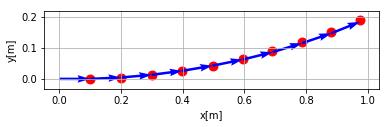

 ---------------------------------------------------------------------------------------------- 
 --- input --- 
[[ 9.99986198e-02 -7.83161687e-08 -1.54349554e+00]
 [ 1.99980680e-01  1.81971779e-03 -1.52529554e+00]
 [ 2.99913063e-01  5.45878554e-03 -1.50709554e+00]
 [ 3.99762668e-01  1.09159196e-02 -1.48889554e+00]
 [ 4.99496422e-01  1.81893123e-02 -1.47069554e+00]
 [ 5.99081290e-01  2.72765546e-02 -1.45249554e+00]
 [ 6.98484287e-01  3.81746364e-02 -1.43429554e+00]
 [ 7.97672487e-01  5.08799480e-02 -1.41609554e+00]
 [ 8.96613036e-01  6.53882810e-02 -1.39789554e+00]
 [ 9.95273162e-01  8.16948298e-02 -1.37969554e+00]]
 --- output --- 
[[[ 0.1         0.          0.01869433]
  [ 0.1         0.          0.01786909]
  [ 0.1         0.          0.01764072]
  [ 0.1         0.          0.01552053]
  [ 0.1         0.          0.00776672]
  [ 0.1         0.          0.02065876]
  [ 0.1         0.          0.04492505]
  [ 0.1         0.         -0.05235988]
  [ 0.1         0.          0.05235988]

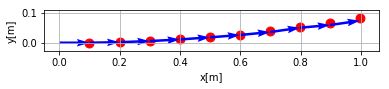

 ---------------------------------------------------------------------------------------------- 
 --- input --- 
[[ 9.99918158e-02 -4.98070605e-07 -1.50431135e+00]
 [ 1.99885465e-01  4.42919095e-03 -1.45999135e+00]
 [ 2.99484761e-01  1.32803674e-02 -1.41567135e+00]
 [ 3.98594099e-01  2.65356481e-02 -1.37135135e+00]
 [ 4.97018832e-01  4.41690005e-02 -1.32703135e+00]
 [ 5.94565661e-01  6.61457937e-02 -1.28271135e+00]
 [ 6.91043008e-01  9.24228666e-02 -1.23839135e+00]
 [ 7.86261400e-01  1.22948613e-01 -1.19407135e+00]
 [ 8.80033831e-01  1.57663081e-01 -1.14975135e+00]
 [ 9.72176140e-01  1.96498094e-01 -1.10543135e+00]]
 --- output --- 
[[[0.1        0.         0.04732519]
  [0.1        0.         0.04312816]
  [0.1        0.         0.04349786]
  [0.1        0.         0.04028688]
  [0.1        0.         0.03538802]
  [0.1        0.         0.04214622]
  [0.1        0.         0.05235988]
  [0.1        0.         0.03828175]
  [0.1        0.         0.05235988]
  [0.1        0.         0

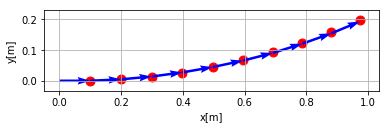

 ---------------------------------------------------------------------------------------------- 
 --- input --- 
[[ 9.99995493e-02  3.99077485e-07 -1.58640032e+00]
 [ 1.99993695e-01 -1.03917843e-03 -1.59680032e+00]
 [ 2.99971621e-01 -3.11862009e-03 -1.60720032e+00]
 [ 3.99922515e-01 -6.23770098e-03 -1.61760032e+00]
 [ 4.99835566e-01 -1.03960838e-02 -1.62800032e+00]
 [ 5.99699967e-01 -1.55933186e-02 -1.63840032e+00]
 [ 6.99504918e-01 -2.18288435e-02 -1.64880032e+00]
 [ 7.99239622e-01 -2.91019840e-02 -1.65920032e+00]
 [ 8.98893294e-01 -3.74119533e-02 -1.66960032e+00]
 [ 9.98455154e-01 -4.67578527e-02 -1.68000032e+00]]
 --- output --- 
[[[ 0.1         0.         -0.011012  ]
  [ 0.1         0.         -0.00879232]
  [ 0.1         0.         -0.01182029]
  [ 0.1         0.         -0.01334218]
  [ 0.1         0.         -0.0226643 ]
  [ 0.1         0.         -0.00393329]
  [ 0.1         0.         -0.0020473 ]
  [ 0.1         0.         -0.05235988]
  [ 0.1         0.          0.04345691]

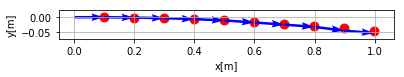

 ---------------------------------------------------------------------------------------------- 
 --- input --- 
[[ 9.99998444e-02 -2.44068482e-08 -1.56163108e+00]
 [ 1.99997822e-01  6.10946435e-04 -1.55552108e+00]
 [ 2.99990201e-01  1.83288972e-03 -1.54941108e+00]
 [ 3.99973247e-01  3.66575982e-03 -1.54330108e+00]
 [ 4.99943228e-01  6.10948832e-03 -1.53719108e+00]
 [ 5.99896412e-01  9.16398399e-03 -1.53108108e+00]
 [ 6.99829067e-01  1.28291328e-02 -1.52497108e+00]
 [ 7.99737463e-01  1.71047979e-02 -1.51886108e+00]
 [ 8.99617870e-01  2.19908197e-02 -1.51275108e+00]
 [ 9.99466559e-01  2.74870158e-02 -1.50664108e+00]]
 --- output --- 
[[[ 0.1         0.          0.00588041]
  [ 0.1         0.          0.00643127]
  [ 0.1         0.          0.00529044]
  [ 0.1         0.          0.00350075]
  [ 0.1         0.         -0.00512   ]
  [ 0.1         0.          0.01036504]
  [ 0.1         0.          0.02494304]
  [ 0.1         0.         -0.05235988]
  [ 0.1         0.          0.05235988]

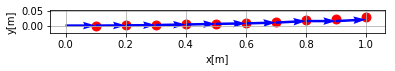

 ---------------------------------------------------------------------------------------------- 
 --- input --- 
[[ 9.99915064e-02 -2.57620944e-08 -1.50307107e+00]
 [ 1.99881114e-01  4.51303131e-03 -1.45792107e+00]
 [ 2.99465230e-01  1.35299728e-02 -1.41277107e+00]
 [ 3.98540884e-01  2.70324206e-02 -1.36762107e+00]
 [ 4.96906143e-01  4.49928544e-02 -1.32247107e+00]
 [ 5.94360521e-01  6.73746676e-02 -1.27732107e+00]
 [ 6.90705388e-01  9.41322421e-02 -1.23217107e+00]
 [ 7.85744378e-01  1.25211041e-01 -1.18702107e+00]
 [ 8.79283784e-01  1.60547721e-01 -1.14187107e+00]
 [ 9.71132955e-01  2.00070259e-01 -1.09672107e+00]]
 --- output --- 
[[[0.1        0.         0.04825278]
  [0.1        0.         0.04394022]
  [0.1        0.         0.04429836]
  [0.1        0.         0.04104449]
  [0.1        0.         0.03625777]
  [0.1        0.         0.04281005]
  [0.1        0.         0.05235988]
  [0.1        0.         0.04130175]
  [0.1        0.         0.05235988]
  [0.1        0.         0

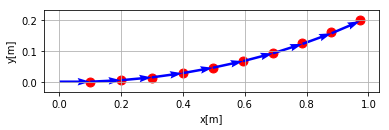

 ---------------------------------------------------------------------------------------------- 
 --- input --- 
[[ 9.99979391e-02 -6.31105354e-10 -1.53743632e+00]
 [ 1.99971149e-01  2.22376957e-03 -1.51519632e+00]
 [ 2.99870183e-01  6.67021074e-03 -1.49295632e+00]
 [ 3.99645631e-01  1.33371237e-02 -1.47071632e+00]
 [ 4.99248145e-01  2.22212110e-02 -1.44847632e+00]
 [ 5.98628462e-01  3.33180785e-02 -1.42623632e+00]
 [ 6.97737428e-01  4.66222379e-02 -1.40399632e+00]
 [ 7.96526025e-01  6.21271088e-02 -1.38175632e+00]
 [ 8.94945391e-01  7.98250228e-02 -1.35951632e+00]
 [ 9.92946849e-01  9.97072263e-02 -1.33727632e+00]]
 --- output --- 
[[[ 0.1         0.          0.02304754]
  [ 0.1         0.          0.021735  ]
  [ 0.1         0.          0.02172204]
  [ 0.1         0.          0.01946642]
  [ 0.1         0.          0.01206782]
  [ 0.1         0.          0.02405576]
  [ 0.1         0.          0.05162205]
  [ 0.1         0.         -0.04172712]
  [ 0.1         0.          0.05235988]

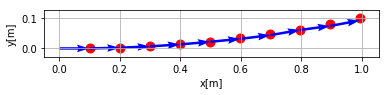

 ---------------------------------------------------------------------------------------------- 
 --- input --- 
[[ 9.99895545e-02 -2.61749270e-07 -1.49568871e+00]
 [ 1.99853811e-01  5.00386221e-03 -1.44561871e+00]
 [ 2.99342462e-01  1.49998291e-02 -1.39554871e+00]
 [ 3.98206141e-01  2.99625843e-02 -1.34547871e+00]
 [ 4.96197047e-01  4.98546239e-02 -1.29540871e+00]
 [ 5.93069569e-01  7.46260888e-02 -1.24533871e+00]
 [ 6.88580898e-01  1.04214890e-01 -1.19526871e+00]
 [ 7.82491635e-01  1.38546863e-01 -1.14519871e+00]
 [ 8.74566396e-01  1.77535957e-01 -1.09512871e+00]
 [ 9.64574397e-01  2.21084445e-01 -1.04505871e+00]]
 --- output --- 
[[[0.1        0.         0.05235988]
  [0.1        0.         0.04856987]
  [0.1        0.         0.04914609]
  [0.1        0.         0.04551286]
  [0.1        0.         0.04146972]
  [0.1        0.         0.04654305]
  [0.1        0.         0.05235988]
  [0.1        0.         0.05235988]
  [0.1        0.         0.05235988]
  [0.1        0.         0

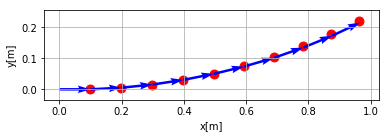

 ---------------------------------------------------------------------------------------------- 
 --- input --- 
[[ 9.99989873e-02  1.72335401e-07 -1.59418305e+00]
 [ 1.99985825e-01 -1.55857641e-03 -1.60977305e+00]
 [ 2.99936213e-01 -4.67586740e-03 -1.62536305e+00]
 [ 3.99825857e-01 -9.35094299e-03 -1.64095305e+00]
 [ 4.99630482e-01 -1.55826669e-02 -1.65654305e+00]
 [ 5.99325830e-01 -2.33695247e-02 -1.67213305e+00]
 [ 6.98887670e-01 -3.27096236e-02 -1.68772305e+00]
 [ 7.98291805e-01 -4.36006938e-02 -1.70331305e+00]
 [ 8.97514075e-01 -5.60400881e-02 -1.71890305e+00]
 [ 9.96530365e-01 -7.00247833e-02 -1.73449305e+00]]
 --- output --- 
[[[ 0.1         0.         -0.01615799]
  [ 0.1         0.         -0.0134659 ]
  [ 0.1         0.         -0.0172374 ]
  [ 0.1         0.         -0.01871918]
  [ 0.1         0.         -0.02814612]
  [ 0.1         0.         -0.0084688 ]
  [ 0.1         0.         -0.0104259 ]
  [ 0.1         0.         -0.05235988]
  [ 0.1         0.          0.03045369]

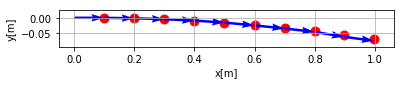

 ---------------------------------------------------------------------------------------------- 
 --- input --- 
[[ 9.99886382e-02  4.30166778e-07 -1.64913063e+00]
 [ 1.99840999e-01 -5.21817420e-03 -1.70135063e+00]
 [ 2.99284854e-01 -1.56415856e-02 -1.75357063e+00]
 [ 3.98049088e-01 -3.12413865e-02 -1.80579063e+00]
 [ 4.95864440e-01 -5.19750471e-02 -1.85801063e+00]
 [ 5.92464235e-01 -7.77860411e-02 -1.91023063e+00]
 [ 6.87585112e-01 -1.08604000e-01 -1.96245063e+00]
 [ 7.80967741e-01 -1.44344903e-01 -2.01467063e+00]
 [ 8.72357534e-01 -1.84911312e-01 -2.06689063e+00]
 [ 9.61505334e-01 -2.30192628e-01 -2.11911063e+00]]
 --- output --- 
[[[ 0.1         0.         -0.04960457]
  [ 0.1         0.         -0.04263154]
  [ 0.1         0.         -0.05235988]
  [ 0.1         0.         -0.05235988]
  [ 0.1         0.         -0.05235988]
  [ 0.1         0.         -0.03669395]
  [ 0.1         0.         -0.05235988]
  [ 0.1         0.         -0.05235988]
  [ 0.1         0.         -0.05235988]

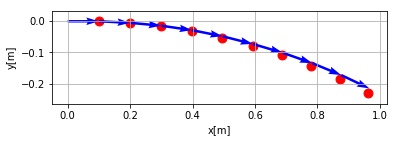

 ---------------------------------------------------------------------------------------------- 


In [15]:
for i in range(10):
    rand_rad = xp.random.rand()*(2*DATA_W_STEP)-DATA_W_STEP # -36 ~ 36 m/step
    d = data.generate_arc_path(DATA_NUM_STEP,rand_rad,DATA_V_STEP)
    d = data.rotate_path(d,rand_rad*0.5)
    if DATA_RANGE_TRANSLATE != 0:
        rand_trans_x = xp.random.rand() * DATA_RANGE_TRANSLATE
        d = data.translate_path(d,rand_trans_x,0.0)
    if DATA_RANGE_ROTATE != 0:
        rand_rotate = xp.random.rand()*(DATA_RANGE_ROTATE*2)-DATA_RANGE_ROTATE
        d = data.rotate_path(d,rand_rotate)
    
    x_test = d
    x = x_test[:,0:2]
    if DATA_NUM_PREVIOUS_U:
        prev_u = xp.array([.0,.0],dtype=xp.float32)
        x = xp.vstack((x,prev_u))
    x = xp.ravel(x)
    x = Variable(xp.array([x],dtype=xp.float32))
    y_v,y_w = model(x)
    # clip
    v_limit = DATA_MAX_V_STEP
    w_limit = DATA_MAX_W_STEP
    v = F.clip(y_v,0.0,v_limit)
    w = F.clip(y_w,-w_limit,w_limit)
    # zero-padding
    pad = Variable(xp.zeros((1,DATA_NUM_STEP),dtype=xp.float32))
    y_pad = F.stack((v,pad,w),axis=2)
    print(' --- input --- ')
    print(x_test)
    print(' --- output --- ')
    print(y_pad.data)
    # loss
    z_true = x_test
    z = y_pad[0,0]
    e = error_squares(z,z_true[0])
    print(' --- error --- ')
    print('loss:',e)
    Z = xp.array([([0,0,0]),(z.data)],dtype='float32')
    for step in range(1,DATA_NUM_STEP):
        z = oplus(z,y_pad[0,step])
        e = error_squares(z,z_true[step])
        print('loss:',e)
        Z = xp.vstack((Z,z.data))
    #print(' --- trajectory --- ')
    #print(Z)
    #print(z_true.shape)
    fig = plot_path(Z,z_true)
    #fig.savefig(dirname + '/test' + str(i) + '.png')
    print(' ---------------------------------------------------------------------------------------------- ')

In [16]:
'''
x = xp.array([ 0.04362432, -0.01988486,  0.0504621,  -0.06733729,  0.01422674,
           -0.09872974, -0.03176716, -0.08520015, -0.04523301, -0.03918755,
           -0.01379037, -0.00299572,  0.03365254, -0.00989925,  0.05347693,
           -0.05355108,  0.02745634, -0.09381791, -0.02048601, -0.09367861],dtype=xp.float32)
x_test = xp.reshape(x,(10,2))
y_v =xp.array([[ 0.05098518,  0.05301605,  0.04617335,  0.05058391,  0.04857601,  0.04970181,
   0.05061447,  0.0512807,   0.05293243,  0.04999607]],dtype=xp.float32)
y_w =xp.array([[-0.0903318,  -0.09855502, -0.08380567, -0.08425293, -0.23067333, -0.0578969,
  -0.1067691,  -0.14234726, -0.06991683, -0.10047609]],dtype=xp.float32)
 
# clip
v_limit = DATA_MAX_V_STEP
w_limit = DATA_MAX_W_STEP
v = F.clip(y_v,0.0,v_limit)
w = F.clip(y_w,-w_limit,w_limit)
# zero-padding
pad = Variable(xp.zeros((1,DATA_NUM_STEP),dtype=xp.float32))
y_pad = F.stack((v,pad,w),axis=2)
print(' --- input --- ')
print(x_test)
print('v')
print(v)
print('w')
print(w)
print(' --- output --- ')
print(y_pad.data)
z_true = x_test
z = y_pad[0,0]
Z = xp.array([([0,0,0]),(z.data)],dtype='float32')
for step in range(1,DATA_NUM_STEP):
    z = oplus(z,y_pad[0,step])
    Z = xp.vstack((Z,z.data))
#print(' --- trajectory --- ')
#print(Z)
#print(z_true.shape)
fig = plot_path(Z,z_true)
'''

"\nx = xp.array([ 0.04362432, -0.01988486,  0.0504621,  -0.06733729,  0.01422674,\n           -0.09872974, -0.03176716, -0.08520015, -0.04523301, -0.03918755,\n           -0.01379037, -0.00299572,  0.03365254, -0.00989925,  0.05347693,\n           -0.05355108,  0.02745634, -0.09381791, -0.02048601, -0.09367861],dtype=xp.float32)\nx_test = xp.reshape(x,(10,2))\ny_v =xp.array([[ 0.05098518,  0.05301605,  0.04617335,  0.05058391,  0.04857601,  0.04970181,\n   0.05061447,  0.0512807,   0.05293243,  0.04999607]],dtype=xp.float32)\ny_w =xp.array([[-0.0903318,  -0.09855502, -0.08380567, -0.08425293, -0.23067333, -0.0578969,\n  -0.1067691,  -0.14234726, -0.06991683, -0.10047609]],dtype=xp.float32)\n \n# clip\nv_limit = DATA_MAX_V_STEP\nw_limit = DATA_MAX_W_STEP\nv = F.clip(y_v,0.0,v_limit)\nw = F.clip(y_w,-w_limit,w_limit)\n# zero-padding\npad = Variable(xp.zeros((1,DATA_NUM_STEP),dtype=xp.float32))\ny_pad = F.stack((v,pad,w),axis=2)\nprint(' --- input --- ')\nprint(x_test)\nprint('v')\nprint(